In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


### Importing libraries

In [7]:
from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator

### Loading the datasets

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. **The first column**, called **"label"**, is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [8]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data visualisation

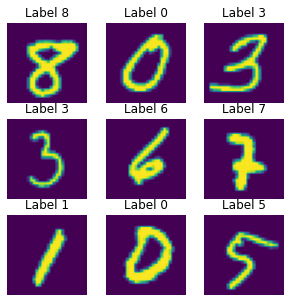

In [9]:
from PIL import Image

fig = plt.figure(figsize=(5, 5))

rows = 3
columns = 3

for i in range(9):
    j=np.random.randint(0,28000)
    fig.add_subplot(rows, columns, i+1)
    img_arr=train.iloc[j,1:].values.reshape(28,28)
    label=str(train.iloc[j,0])
    plt.imshow(img_arr)
    plt.axis('off')
    plt.title("Label"+' '+label)

### Creating the training data

In [10]:
X_train = (train.iloc[:,1:].values).astype('float32')
y_train = train.iloc[:,0].values.astype('int32')
X_test = test.values.astype('float32')
X_train.shape

(42000, 784)

In [11]:
'''
divided all of the data by 255.0, is meant for normalize the dataset value
if its not divied by 255.0, then the neural network will be constant,

reshaping it to 28,28,1 from x, 784. is meant for inputing it to Conv2D
'''
X_train/=255.0
X_train=X_train.reshape(-1,28,28,1)
X_train.shape

(42000, 28, 28, 1)

In [12]:
X_test/=255.0
X_test=X_test.reshape(-1,28,28,1)
X_test.shape

(28000, 28, 28, 1)

### Creating the model

In [13]:
from tensorflow import keras
'''
Conv2D will read the shape of 4D dimension (num, height, weight, channels)
MaxPooling2D will project it to lower dimension, to accerelate the process
Flatten will reduce the size to 1D array
Dense is a normal neuron point
Dropout will throw away all the unneccesary neuron

'''
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 128)         147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         1

### Compiling the model

In [15]:
model.compile(
    loss="sparse_categorical_crossentropy", # multyclass classification
    optimizer = 'nadam', # optimizer
    metrics=['accuracy']
)

### Cross validation

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Fitting the model

In [17]:
history = model.fit(X_train,y_train,
                   validation_data=(X_valid,y_valid),
                   epochs=10)

Epoch 1/10
1182/1182 [==============================] - 128s 107ms/step - loss: 0.8004 - accuracy: 0.7304 - val_loss: 0.3165 - val_accuracy: 0.9190
Epoch 2/10
1182/1182 [==============================] - 127s 107ms/step - loss: 0.1267 - accuracy: 0.9703 - val_loss: 0.0880 - val_accuracy: 0.9764
Epoch 3/10
1182/1182 [==============================] - 126s 107ms/step - loss: 0.0883 - accuracy: 0.9793 - val_loss: 0.0565 - val_accuracy: 0.9860
Epoch 4/10
1182/1182 [==============================] - 127s 107ms/step - loss: 0.0749 - accuracy: 0.9830 - val_loss: 0.0713 - val_accuracy: 0.9817
Epoch 5/10
1182/1182 [==============================] - 126s 107ms/step - loss: 0.0632 - accuracy: 0.9858 - val_loss: 0.0515 - val_accuracy: 0.9864
Epoch 6/10
1182/1182 [==============================] - 126s 107ms/step - loss: 0.0529 - accuracy: 0.9877 - val_loss: 0.0511 - val_accuracy: 0.9883
Epoch 7/10
1182/1182 [==============================] - 126s 107ms/step - loss: 0.0570 - accuracy: 0.9873 - val_

<AxesSubplot:>

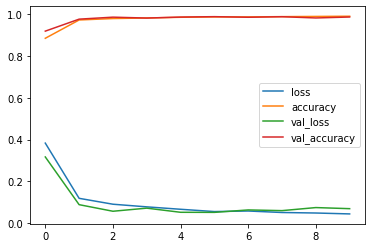

In [18]:
pd.DataFrame(history.history).plot()

### Predictions

In [19]:
pred = model.predict(X_test)
pred

array([[1.35149414e-33, 2.23988098e-31, 1.00000000e+00, ...,
        1.31989507e-25, 1.68752046e-26, 4.15055009e-37],
       [1.00000000e+00, 1.04989461e-17, 2.05054342e-16, ...,
        7.37705611e-23, 2.49352743e-11, 1.50138400e-15],
       [1.28139218e-15, 5.42447565e-15, 8.70558274e-19, ...,
        4.95044672e-10, 5.03214936e-09, 9.99930739e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.27212676e-34, ...,
        6.14908319e-38, 4.94260748e-37, 2.28145650e-37],
       [1.03077682e-07, 3.75746652e-07, 4.12768664e-09, ...,
        6.26180918e-05, 1.15581934e-04, 9.76465166e-01],
       [3.44639004e-23, 7.77661736e-21, 1.00000000e+00, ...,
        1.98251668e-17, 5.80599230e-18, 8.84140610e-25]], dtype=float32)

In [20]:
# select the index with the maximum probability
pred = np.argmax(pred,axis = 1)
pred

array([2, 0, 9, ..., 3, 9, 2])

### Submission

In [21]:
submission=pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [22]:
submission['Label'] = pred
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [23]:
submission.to_csv('digit_recognition.csv',index=False)